In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from glob import glob
from scipy.interpolate import griddata

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sea_clearly.output_refinery import output_refinery,output_refinery_nearby

import cartopy.crs as ccrs


In [64]:
# data = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Mikael/SeaClearly/Output/advection.zarr')
land_mask = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Mikael/SeaClearly/Input/landmask.nc')
X_land,Y_land = np.meshgrid(land_mask['lon'],land_mask['lat'])

dlon_coarse = .2
dlat_coarse = .2
x_land_coarse = np.arange(land_mask['lon'].min(),land_mask['lon'].max()+dlon_coarse,dlon_coarse)
y_land_coarse = np.arange(land_mask['lat'].min(),land_mask['lat'].max()+dlat_coarse,dlat_coarse)
bins_x_land_coarse = np.insert( .5*(x_land_coarse[1:] + x_land_coarse[:-1]),[0,len(x_land_coarse)-1],[x_land_coarse[0]-.5*dlon_coarse,x_land_coarse[-1]+.5*dlon_coarse])
bins_y_land_coarse = np.insert( .5*(y_land_coarse[1:] + y_land_coarse[:-1]),[0,len(y_land_coarse)-1],[y_land_coarse[0]-.5*dlat_coarse,y_land_coarse[-1]+.5*dlat_coarse])

X_land_coarse,Y_land_coarse = np.meshgrid(x_land_coarse,y_land_coarse)
land_mask_coarse = griddata((X_land.ravel(),Y_land.ravel()),land_mask['mask_land'].values.ravel(),(X_land_coarse,Y_land_coarse),method='nearest')

In [65]:
bins_y_land_coarse

array([30.0875, 30.2875, 30.4875, 30.6875, 30.8875, 31.0875, 31.2875,
       31.4875, 31.6875, 31.8875, 32.0875, 32.2875, 32.4875, 32.6875,
       32.8875, 33.0875, 33.2875, 33.4875, 33.6875, 33.8875, 34.0875,
       34.2875, 34.4875, 34.6875, 34.8875, 35.0875, 35.2875, 35.4875,
       35.6875, 35.8875, 36.0875, 36.2875, 36.4875, 36.6875, 36.8875,
       37.0875, 37.2875, 37.4875, 37.6875, 37.8875, 38.0875, 38.2875,
       38.4875, 38.6875, 38.8875, 39.0875, 39.2875, 39.4875, 39.6875,
       39.8875, 40.0875, 40.2875, 40.4875, 40.6875, 40.8875, 41.0875,
       41.2875, 41.4875, 41.6875, 41.8875, 42.0875, 42.2875, 42.4875,
       42.6875, 42.8875, 43.0875, 43.2875, 43.4875, 43.6875, 43.8875,
       44.0875, 44.2875, 44.4875, 44.6875, 44.8875, 45.0875, 45.2875,
       45.4875, 45.6875, 45.8875, 46.0875])

In [4]:
# def refine_merge(files):
files = sorted(glob('/storage/shared/oceanparcels/output_data/data_Mikael/SeaClearly/Output/*bwd*'))
lon_refine = 5
lat_refine = 39

def refine_concat(files):
    for i1,file in enumerate(files):
        data = xr.open_zarr(file)
        if i1==0:
            data_refined = output_refinery_nearby(data,lon_refine,lat_refine)
        else:
            data_concat = output_refinery_nearby(data,lon_refine,lat_refine)
            data_refined = xr.concat([data_refined,data_concat],dim='traj')
    return data_refined

data_refined = refine_concat(files)

(35.078330993652344, 44.34931945800781)

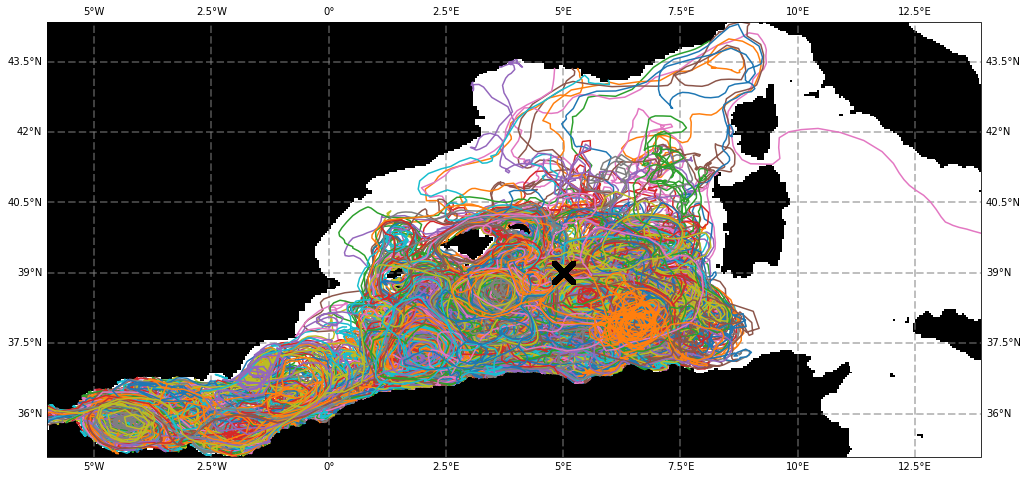

In [6]:
fig = plt.figure(figsize=(32,8))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines(resolution='50m')
ax.pcolormesh(X_land, Y_land, land_mask['mask_land'][:-1,:-1],cmap='Greys')

for i1 in range(len(data_refined['traj'])):
    ax.plot(data_refined['lon'][i1,:].values,data_refined['lat'][i1,:].values,'-')
for i1 in range(len(data_refined['traj'])):
    ax.plot(data_refined['lon'][i1,0].values,data_refined['lat'][i1,0].values,'kx',markersize=20)
    
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax.set_xlim(data_refined['lon'].min(),data_refined['lon'].max())
ax.set_ylim(data_refined['lat'].min(),data_refined['lat'].max())

In [8]:
data_refined

<xarray.Dataset>
Dimensions:     (traj: 512, obs: 301)
Dimensions without coordinates: traj, obs
Data variables:
    lat         (traj, obs) float32 dask.array<chunksize=(16, 19), meta=np.ndarray>
    lon         (traj, obs) float32 dask.array<chunksize=(16, 19), meta=np.ndarray>
    time        (traj, obs) datetime64[ns] dask.array<chunksize=(16, 19), meta=np.ndarray>
    trajectory  (traj, obs) float64 dask.array<chunksize=(16, 19), meta=np.ndarray>
    z           (traj, obs) float32 dask.array<chunksize=(16, 19), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.0-239-g31f81d51

/tmp/ipykernel_1306327/1476564667.py:6: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(x_land, y_land, np.log10(hist[0].T))


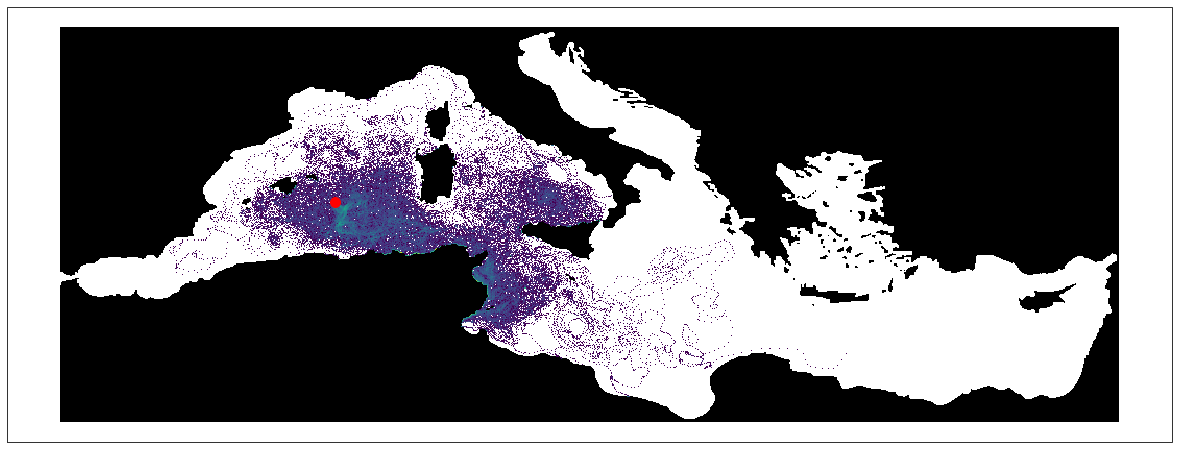

In [64]:
hist = np.histogram2d(data_refined['lon'].values.ravel(),data_refined['lat'].values.ravel(),bins=[land_mask['lon'],land_mask['lat']])

fig = plt.figure(figsize=(32,8))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines(resolution='50m')
ax.pcolormesh(X_land, Y_land, land_mask['mask_land'][:-1,:-1],cmap='Greys')

ax.pcolormesh(X_land, Y_land, np.log10(hist[0].T))

for i1 in range(1):
    ax.plot(data_refined['lon'][i1,0].values,data_refined['lat'][i1,0].values,'ro',markersize=10)
    

/tmp/ipykernel_1710470/997529516.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(X_land_coarse, Y_land_coarse, np.log10(hist[0].T))


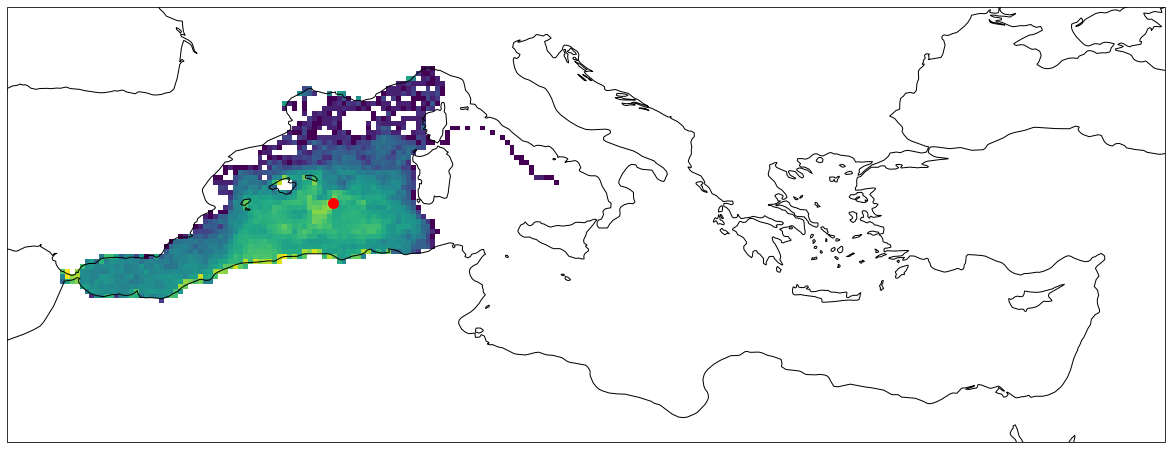

In [66]:
hist = np.histogram2d(data_refined['lon'].values.ravel(),data_refined['lat'].values.ravel(),bins=[bins_x_land_coarse,bins_y_land_coarse])

fig = plt.figure(figsize=(32,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
# ax.pcolormesh(X_land_coarse, Y_land_coarse, land_mask_coarse[:-1,:-1],cmap='Greys')

ax.pcolormesh(X_land_coarse, Y_land_coarse, np.log10(hist[0].T))

for i1 in range(1):
    ax.plot(data_refined['lon'][i1,0].values,data_refined['lat'][i1,0].values,'ro',markersize=10)
    


In [39]:
input_coasts = xr.load_dataset('../data/coastal_MPW_input.nc')
input_rivers = xr.load_dataset('../data/riverine_input.nc')

X_coast,Y_coast = np.meshgrid(input_coasts['lon'],input_coasts['lat'])
X_riv,Y_riv = np.meshgrid(input_rivers['lon'],input_rivers['lat'])

from sea_clearly.create_masks import get_coastal_nodes
coast_coarse = get_coastal_nodes(land_mask_coarse)
mask_coast_coarse = coast_coarse == 1
mask_input_coast = input_coasts['MPW'] > 0

vals_coast_coarse = griddata((X_coast[mask_input_coast],Y_coast[mask_input_coast]),
                               input_coasts['MPW'].values[mask_input_coast],
                               (X_land_coarse[mask_coast_coarse],Y_land_coarse[mask_coast_coarse]),method='nearest')
input_coast_coarse = np.zeros(land_mask_coarse.shape)
input_coast_coarse[mask_coast_coarse] = vals_coast_coarse

/tmp/ipykernel_1710470/2997266897.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(input_coast_coarse))


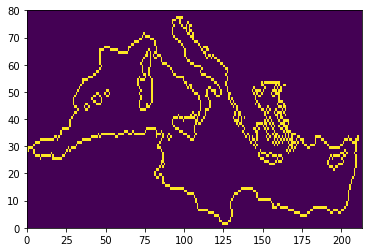

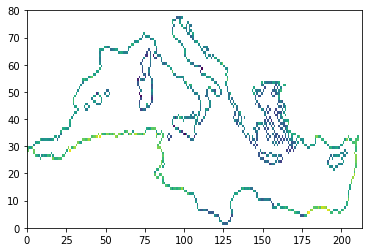

In [40]:
plt.figure()
plt.pcolormesh(coast_coarse)

plt.figure()
plt.pcolormesh(np.log10(input_coast_coarse))

/tmp/ipykernel_1710470/3656301696.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(hist[0].T))
/tmp/ipykernel_1710470/3656301696.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(posterior))


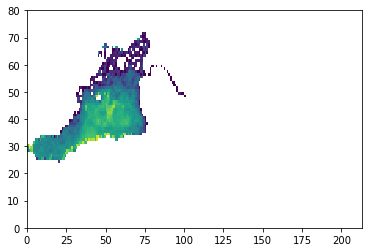

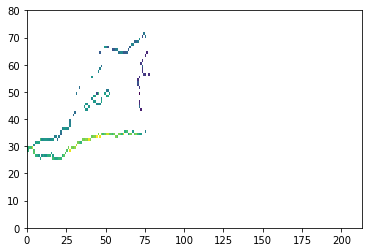

In [68]:
hist[0].shape

plt.pcolormesh(np.log10(hist[0].T))

posterior = hist[0].T * input_coast_coarse

plt.figure()
plt.pcolormesh(np.log10(posterior))